### Imports

In [ ]:
!rm -rf qber-forecasting
!rm -rf deep_qber
!git clone https://github.com/rmnigm/qber-forecasting.git
!cp -r qber-forecasting/deep_qber deep_qber

In [19]:
!pip install catboost
!pip install pytorch_lightning

In [1]:
import os
import random
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score

import catboost
from catboost import Pool, CatBoostRegressor, CatBoostClassifier

### Outlier Labeling

In [5]:
dataframe = pd.read_csv("../datasets/qber_with_outliers.csv").drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
# dataset = dataframe.values.astype('float32')

In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184850 entries, 0 to 184849
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   e_mu_current    184850 non-null  float64
 1   e_mu_estimated  184850 non-null  float64
 2   e_nu_1          184850 non-null  float64
 3   e_nu_2          184850 non-null  float64
 4   q_mu            184850 non-null  float64
 5   q_nu1           184850 non-null  float64
 6   q_nu2           184850 non-null  float64
 7   outliers        184850 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 11.3 MB


In [6]:
dataframe.head()

,e_mu_current,e_mu_estimated,e_nu_1,e_nu_2,q_mu,q_nu1,q_nu2,outliers
0,0.01298,0.01164,0.01904,0.17794,0.550377,0.164911,0.008094,0
1,0.01283,0.00961,0.01672,0.20868,0.564295,0.167629,0.006639,0
2,0.01268,0.00590,0.01337,0.20442,0.564179,0.164110,0.007052,0
3,0.01129,0.00988,0.01637,0.18453,0.573555,0.167174,0.006663,0
4,0.01169,0.01338,0.01783,0.11478,0.569296,0.169658,0.006823,0


In [8]:
target = 'e_mu_current'

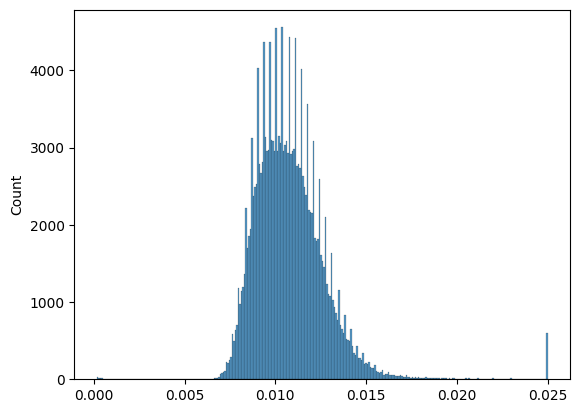

In [15]:
sns.histplot(dataframe[target].values.clip(0, 0.025))
plt.show()

In [9]:
mean, std = dataframe[target].mean(), dataframe[target].std()

In [146]:
dataframe['e_mu_current_dev'] = np.abs(dataframe[target] - mean)
dataframe['e_mu_current_dev_sigma'] = np.abs(dataframe[target] - mean ) / std
dataframe['e_mu_current_rmean_w_5'] = dataframe['e_mu_current'].rolling(window=5).mean()
dataframe['e_mu_current_rmean_w_30'] = dataframe['e_mu_current'].rolling(window=30).mean()
dataframe['e_mu_current_rmean_w_100'] = dataframe['e_mu_current'].rolling(window=100).mean()
dataframe['e_mu_current_rstd_w_5'] = dataframe['e_mu_current'].rolling(window=5).std()
dataframe['e_mu_current_rstd_w_30'] = dataframe['e_mu_current'].rolling(window=30).std()
dataframe['e_mu_current_rstd_w_100'] = dataframe['e_mu_current'].rolling(window=100).std()
dataframe['e_mu_current_rdev_w_5'] = dataframe['e_mu_current_rmin_w_5'] - dataframe[target]
dataframe['e_mu_current_rdev_w_30'] = dataframe['e_mu_current_rmin_w_30'] - dataframe[target]
dataframe['e_mu_current_rdev_w_100'] = dataframe['e_mu_current_rmin_w_100'] - dataframe[target]

In [55]:
seq = False
first, last = None, None
intervals = set()
for i, val in enumerate(dataframe['outliers']):
    if val > 0 and not seq:
        first = i
        seq = True
    elif val > 0 and seq:
        last = i
    elif val == 0:
        if first and last:
            intervals.add((first, last))
            first, last = None, None
        seq = False

In [376]:
f = 91150
l = 91641

In [377]:
for i in range(f - 10, f):
    anomalies_info[i] = {
        'class': 'before_anomaly',
        'steps_to_anomaly': f - 1 - i,
        'confidence': 'high',
        'dev': dataframe['e_mu_current_dev'][i],
        'dev_normed_by_std': dataframe['e_mu_current_dev_sigma'][i],
        'running_dev_w_5': dataframe['e_mu_current_rdev_w_5'][i],
        'running_dev_w_30': dataframe['e_mu_current_rdev_w_30'][i],
        'running_dev_w_100': dataframe['e_mu_current_rdev_w_100'][i],
        'running_mean_w_5': dataframe['e_mu_current_rmean_w_5'][i],
        'running_mean_w_30': dataframe['e_mu_current_rmean_w_30'][i],
        'running_mean_w_100': dataframe['e_mu_current_rmean_w_100'][i],
    }


for i in range(f, l):
    anomalies_info[i] = {
        'class': 'anomaly',
        'steps_to_anomaly': 0,
        'confidence': 'low' if i > 91300 else 'high',
        'dev': dataframe['e_mu_current_dev'][i],
        'dev_normed_by_std': dataframe['e_mu_current_dev_sigma'][i],
        'running_dev_w_5': dataframe['e_mu_current_rdev_w_5'][i],
        'running_dev_w_30': dataframe['e_mu_current_rdev_w_30'][i],
        'running_dev_w_100': dataframe['e_mu_current_rdev_w_100'][i],
        'running_mean_w_5': dataframe['e_mu_current_rmean_w_5'][i],
        'running_mean_w_30': dataframe['e_mu_current_rmean_w_30'][i],
        'running_mean_w_100': dataframe['e_mu_current_rmean_w_100'][i],
    }

In [378]:
df = pd.DataFrame.from_dict(anomalies_info, orient='index')

In [379]:
df = df.sort_index()

In [392]:
import time
from IPython.display import clear_output

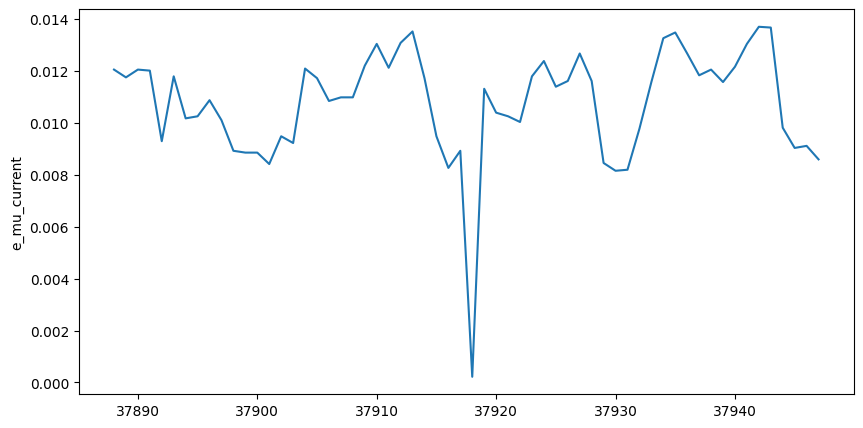

KeyboardInterrupt: 

In [393]:
for i, val in enumerate(dataframe['outliers'] > 0):
    if val and i not in df.index:
        center = i
        f_, l_ = center - 30, center + 30
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=range(f_, l_), y=dataframe[target][f_:l_])
        plt.show()
        time.sleep(3)
        clear_output(wait=True)

In [418]:
dataframe = dataframe.drop(columns=[
    'e_mu_current_dev', 'e_mu_current_dev_sigma',
       'e_mu_current_rmin_w_5', 'e_mu_current_rmin_w_30',
       'e_mu_current_rmin_w_100', 'e_mu_current_std_w_5',
       'e_mu_current_std_w_30', 'e_mu_current_std_w_100',
       'e_mu_current_dev_w_5', 'e_mu_current_dev_w_30',
       'e_mu_current_dev_w_100', 'e_mu_current_rstd_w_5',
       'e_mu_current_rstd_w_30', 'e_mu_current_rstd_w_100',
       'e_mu_current_rdev_w_5', 'e_mu_current_rdev_w_30',
       'e_mu_current_rdev_w_100', 'e_mu_current_rmean_w_5',
       'e_mu_current_rmean_w_30', 'e_mu_current_rmean_w_100'
])

In [2]:
df = pd.read_csv("../datasets/outliers_info.csv")

In [15]:
df.reset_index().to_csv("../datasets/outliers_info.csv", index=False)

### Feature Extraction

In [21]:
def get_features_df(dataframe, look_back=5, train_size=0.75):
    dataset = dataframe.values
    columns = list(dataframe.columns)
    train_size = int(len(dataset) * train_size)
    test_size = len(dataset) - train_size
    data_train, data_test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    print(f"Training set size = {train_size}, testing set size = {test_size}")

    length = data_train.shape[0]
    width = data_train.shape[1]
    x = np.empty((length, look_back + 1, width))
    for i in range(look_back, length):
        x[i] = data_train[(i - look_back):(i + 1), :]

    train_df = pd.DataFrame()
    for i, col in enumerate(columns):
        for lag in range(look_back + 1):
            feature_name = f'{col}_{look_back - lag}_lag'
            train_df[feature_name] = x[look_back:, lag, i]

    length = data_test.shape[0]
    width = data_test.shape[1]
    x = np.empty((length, look_back + 1, width))
    for i in range(look_back, length):
        x[i] = data_train[(i - look_back):(i + 1), :]

    test_df = pd.DataFrame()
    for i, col in enumerate(columns):
        for lag in range(look_back + 1):
            feature_name = f'{col}_{look_back - lag}_lag'
            test_df[feature_name] = x[look_back:, lag, i]

    return train_df, test_df

In [22]:
pulses_stats_file_path = "/content/qber-forecasting/datasets/data.csv"
dataframe = pd.read_csv(pulses_stats_file_path,
                        usecols=range(1, 8),
                        engine='python',
                        )
# dataframe = dataframe[0:100000]
dataset = dataframe.values.astype('float32')

In [295]:
dataframe = pd.read_csv("qber_with_outliers.csv").drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
dataset = dataframe.values.astype('float32')

In [313]:
train_size = 0.75
look_back = 8
target_index = 0
x_train, x_test = get_features_df(dataframe, train_size=train_size, look_back=look_back)

Training set size = 138637, testing set size = 46213


### Model Training and Inference

In [ ]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm

In [329]:
from google.colab import output
output.enable_custom_widget_manager()

In [314]:
drop_cols = ['e_mu_current_0_lag'] + [f'outliers_{k}_lag' for k in range(look_back)]
target_col_name = 'outliers_0_lag'

train_pool = Pool(x_train.drop(columns=drop_cols), x_train[target_col_name])
test_pool = Pool(x_test.drop(columns=drop_cols), x_test[target_col_name])

In [327]:
model = CatBoostClassifier()

In [ ]:
model.fit(train_pool, eval_set=test_pool)
preds = model.predict(test_pool)

In [331]:
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select=f'0-{len(x_train.drop(columns=drop_cols).columns)-1}',
    num_features_to_select=20,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [333]:
preds = model.predict(test_pool)

In [334]:
for metric in (f1_score, accuracy_score, roc_auc_score, recall_score, precision_score):
    print(f'{metric.__name__} value:')
    print(f'{metric(preds, x_test[target_col_name]):.8f}')

f1_score value:
0.99204244
accuracy_score value:
0.99993507
roc_auc_score value:
0.99996740
recall_score value:
1.00000000
precision_score value:
0.98421053


In [335]:
plotting_data = {
    'predicted': preds,
    'actual': x_test[target_col_name],
    'value': x_test['e_mu_current_0_lag']
    }

plotting_data = pd.DataFrame(plotting_data).reset_index()
plotting_data['missed'] = plotting_data['predicted'] != plotting_data['actual']

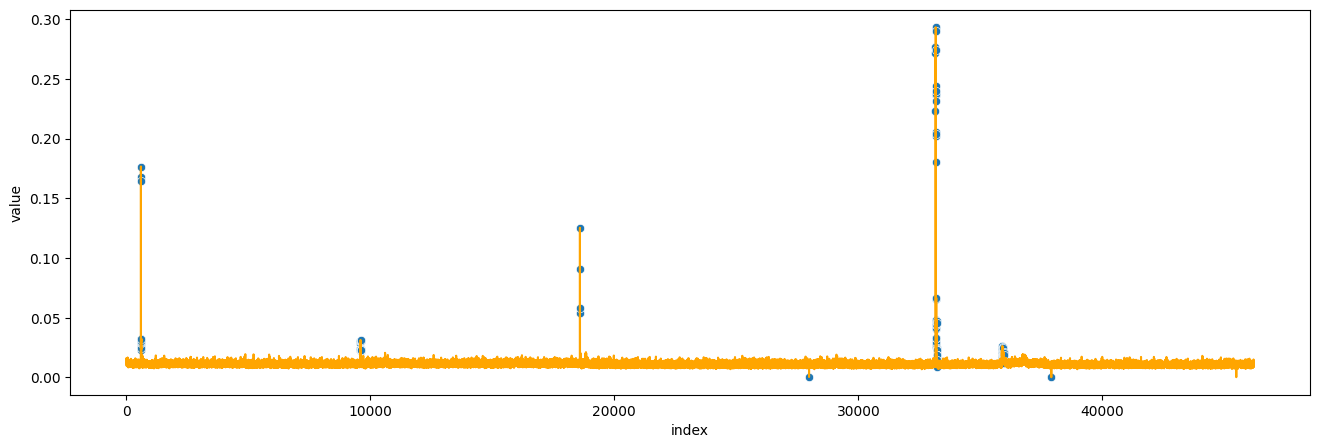

In [336]:
df = plotting_data
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df, x='index', y='value', ax=ax, color='orange')
sns.scatterplot(data=df[df['actual']==1], x='index', y='value', ax=ax)
plt.show()

In [338]:
import time

In [337]:
plotting_data[plotting_data['missed'] == True]

,index,predicted,actual,value,missed
594,594,0.0,1.0,0.02960,True
9589,9589,0.0,1.0,0.02408,True
35881,35881,0.0,1.0,0.02276,True


In [339]:
for i, p in enumerate(plotting_data['missed']):
    if p:
      subset = plotting_data[i - 20:i + 20]
      fig, ax = plt.subplots(figsize=(16, 5))
      sns.lineplot(data=subset, x='index', y='value', ax=ax, color='orange')
      sns.scatterplot(data=subset[(subset['actual']==1) & (subset['missed']==False)], x='index', y='value', ax=ax, color='red')
      sns.scatterplot(data=subset[(subset['actual']==1) & (subset['missed']==True)], x='index', y='value', ax=ax, color='blue')
      plt.show()
      time.sleep(3)
      output.clear()

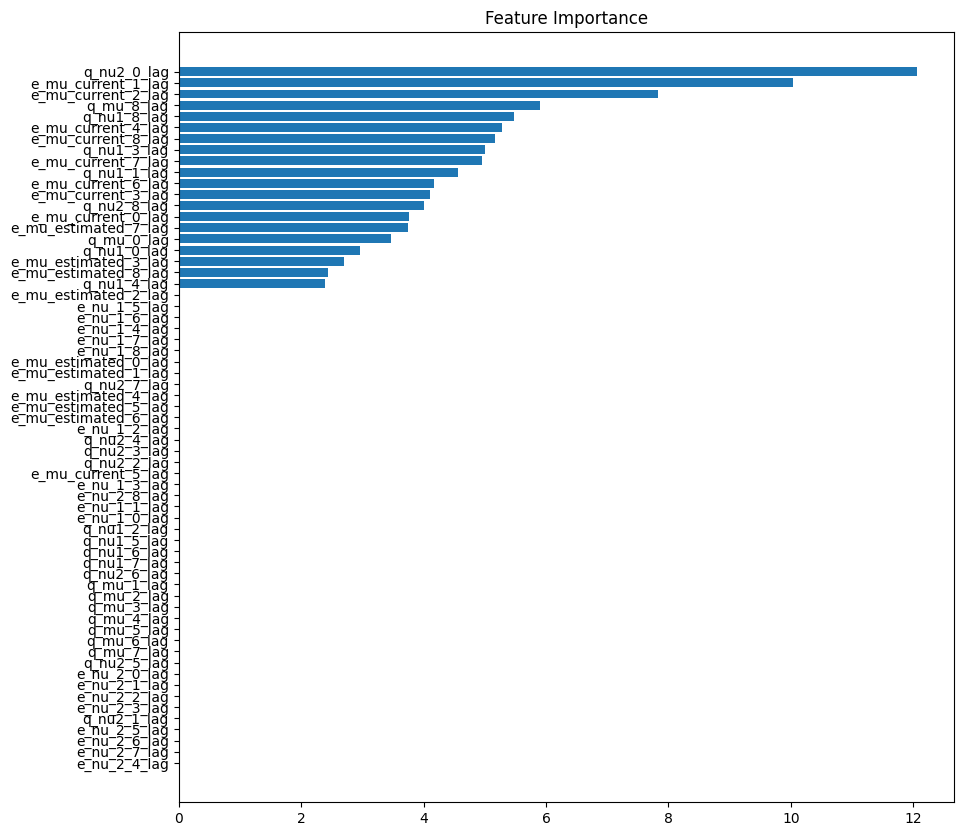

In [340]:
feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()